In [1]:
""" 
dependencies:
  - python=3.8.17
  - numpy=1.24.0
  - matplotlib=3.7.1
  - pandas=2.0.2 
"""
import os
import random
import datetime
from itertools import product 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# import random
# random.seed(42)
# np.random.seed(42)
# np.random.RandomState(42)
# os.environ['TF_DETERMINISTIC_OPS'] = '1' 

finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"
# play sound when finished
# os.system(finish_sound)

In [2]:
# Read data from npy file ( already preprocessed )
filename = 'original-numpy'
# filename = 'pca-numpy'
X_train = np.load(f'dataset/{filename}/X_train.npy')
X_val = np.load(f'dataset/{filename}/X_val.npy')
X_test = np.load(f'dataset/{filename}/X_test.npy')
y_train = np.load(f'dataset/{filename}/y_train.npy')
y_val = np.load(f'dataset/{filename}/y_val.npy')
y_test = np.load(f'dataset/{filename}/y_test.npy')
print(X_train.shape, y_train.shape,'\n', X_val.shape, y_val.shape,'\n', X_test.shape, y_test.shape)

(5120, 10859) (5120, 4) 
 (640, 10859) (640, 4) 
 (640, 10859) (640, 4)


In [3]:
class LogisticRegression():
    # Logistic Regression Model written from scratch without Bias w0
    def __init__(self, seed=42):
        np.random.seed(seed)
        self.W = None
        self.now = None
        self.print_result = True
        self.history_steps1 = None
        self.history = None
        self.validation_accuracy = None
        
    def validation_accuracy(self):
        return self.validation_accuracy
    
    def history(self):
        return self.history
    
    def load_history(self):
        pd_hist = pd.read_csv(f'model-comparison/{self.now}/history.csv')
        self.history = np.array(pd_hist.iloc[:,1:])
        
    def plot(self, save = True):
        # Save history as csv file
        history_local = self.history
        if type(history_local) is not pd.DataFrame:
            history_df = pd.DataFrame(history_local)
        if save == True:
            hist_csv_file = f'model-comparison/{self.now}/history.csv'
            with open(hist_csv_file, mode='w') as f:
                history_df.to_csv(f) 
        # Plot Loss and Accuracy History as Subplots
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(10, 2)
        index = np.arange(1,self.history.shape[1]+1)*self.history_steps1

        ax[0].plot(index, self.history[0], label='Training Loss')
        ax[0].plot(index, self.history[2], label='Validation Loss')
        ax[0].set_title('Loss History')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        ax[1].plot(index, self.history[1], label='Training Accuracy')
        ax[1].plot(index, self.history[3], label='Validation Accuracy')
        ax[1].set_title('Accuracy History')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        if save is True and self.now is not None:
            plt.savefig(f'model-comparison/{self.now}/plot.png')
        if self.print_result == True:
            plt.show()
        else:
            plt.close(fig)
        
    
    def validation(self, X_nonbiased, y, W, lmbda):
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        # Find loss and accuracy on validation set
        y_onehot = y # y is already one-hot encoded
        Z = - X @ W
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        loss = - np.sum(y_onehot * np.log(P)) + lmbda * np.sum(W**2)
        y_pred = self.predict(X_nonbiased)
        accuracy = np.mean(y_pred == np.argmax(y, axis=1))
        return loss, accuracy
    
    def fit(self, X_nonbiased, y, X_val, y_val, now = None, print_result = True,max_epoch=400, 
            batch_size=50000, weight_init='zero', lr=0.01, lr_type = 'static', regularization='l2: 0.01', 
            history_steps = 50, print_step = 100):
        start_time = datetime.datetime.now()
        # if there isn't model-comparison folder, create it
        if not os.path.exists('model-comparison'):
            os.mkdir('model-comparison')
        self.print_result = print_result
        if now is not None:
            self.now = now
        # Create folder for current model
            if not os.path.exists('model-comparison/'+now):
                os.mkdir('model-comparison/'+now)

        self.history_steps1 = history_steps
        self.history = np.zeros((4,max_epoch//history_steps))
        y_onehot = y # y is already one-hot encoded
        lr_print = str(lr) + ' ' + lr_type
        model_specs = 'Logistic Regression | Batch Size: {} | Weight Init. {} | lr: {} | Regularization: {} | Max Epoch: {} |'.format(batch_size, weight_init, lr_print, regularization, max_epoch)
        
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        N = X.shape[0]
        
        # Initialize weights ( shape = features x classes matrix )
        if weight_init == 'zero':
            self.W = np.zeros((X.shape[1], y_onehot.shape[1])) 
        elif weight_init == 'uniform':
            self.W = np.random.uniform(0, 1, (X.shape[1], y_onehot.shape[1]))
        elif weight_init == 'normal':
            self.W = np.random.normal(0, 1, (X.shape[1], y_onehot.shape[1]))
        
        # Print loss and accuracy every 100 iterations or every max_iter//10 iterations if max_iter >= 1000
        if max_epoch >= 1000:
            print_step = max_epoch // 10

        # Gradient Descent
        for epoch in range(1, max_epoch+1):
            # Shuffle all data X and y in the same order every epoch
            shuffle_index = np.arange(X.shape[0])
            np.random.shuffle(shuffle_index)
            X = X[shuffle_index]
            y_onehot = y_onehot[shuffle_index]
            
            for iteration in range(X.shape[0]//batch_size):                                        
                X_batch = X[batch_size*iteration:batch_size*(iteration+1)]
                y_batch = y_onehot[batch_size*iteration:batch_size*(iteration+1)]
                Z_batch = - X_batch @ self.W
                # For numerical stability
                ### Z_batch = Z_batch - np.max(Z_batch, axis=1, keepdims=True)
                # Logistic function to find probabilities
                P_batch = np.exp(Z_batch) / (np.sum(np.exp(Z_batch), axis=1, keepdims=True))                
                N_batch = batch_size
                # Derivative of Residual ( log-loss )
                # P_batch = Softmax(- X_batch @ self.W)
                dRSS = (2/N_batch)*(X_batch.T @ (y_batch - P_batch))
                # Choose regularization
                if regularization[0:2] == 'l2':
                    # L2 regularization
                    lmbda = float(regularization[4:])
                    dRegTerm = 2 * (lmbda) * (N_batch/N) * self.W
                    # Bias term is not regularized
                    dRegTerm[0] *= 0
                    
                elif regularization[0:2] == 'l1':
                    # L1 regularization
                    lmbda = float(regularization[4:])
                    dRegTerm = lmbda * np.sign(self.W) 
                    # Bias term is not regularized
                    dRegTerm[0] *= 0
                else:
                    # No regularization
                    lmbda = 0
                    dRegTerm = 0
                # Calculate gradient
                gradient = dRSS + dRegTerm
            
                if lr_type[0:8] == 'momentum':
                    if epoch == 1:
                        last_gradient = gradient
                    else:
                        momentum = float(lr_type[10:])
                        gradient = gradient + momentum * last_gradient
                        last_gradient = gradient
                    
                # Update weights 
                # ( W already has bias term, so we don't need seperate update, 
                # W is (features+1) x classes matrix: bias is in the first row 
                # and bias is not regularized ) W = (16864+1) x 10
                
                self.W = self.W - lr * (N_batch/N) * gradient
            
                # Change learning rate if lr_type is adaptive
                if lr_type == 'adaptive':
                    if epoch % 300 == 0:                    
                        lr = lr * 2
                        if print_result == True:
                            print('Learning rate changed to', lr)

            # Calculate loss and accuracy every 50 epochs:
            if epoch % history_steps == 0:
                # After each x epoch, calculate loss and accuracy on validation set
                Z = - X @ self.W
                # Numerical stability
                ### Z = Z - np.max(Z, axis=1, keepdims=True)
                P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
                
                loss = - np.sum(y_onehot * np.log(P)) + lmbda * np.sum(self.W**2)
                accuracy = np.mean(self.predict(X_nonbiased) == np.argmax(y, axis=1))
                val_loss = self.validation(X_val, y_val, self.W, lmbda)[0]
                val_acc = self.validation(X_val, y_val, self.W, lmbda)[1]
                self.validation_accuracy = val_acc
                self.history[:,(epoch//history_steps)-1] = np.array([loss, accuracy, val_loss, val_acc])
                
                # Print loss and accuracy every 100 epochs
                if epoch % print_step == 0:
                    line1 = 'Epoch: ' + str(epoch)
                    line2 = ' | Loss: ' + str(loss) + ' | Accuracy: ' + str(accuracy)[0:5]
                    line3 = ' | Val. Loss: ' + str(val_loss) + ' | Val. Acc: ' + str(val_acc)[0:5]
                    # line2 = ' | Loss: ' + str(round(loss)) + ' | Accuracy: ' + str(accuracy)[0:5]
                    # line3 = ' | Val. Loss: ' + str(round(val_loss)) + ' | Val. Acc: ' + str(val_acc)[0:5]
                    if print_result == True:
                        print(line1 + line2 + line3)
                    if now is not None:
                        with open('model-comparison/{}/log.txt'.format(now), 'a') as f:
                            f.write(line1 + line2 + line3 + '\n')
            if epoch == max_epoch:
                end_time = datetime.datetime.now()
                if print_result == True:
                    print('Training finished. Time elapsed:', end_time - start_time, '\n')
                    print('Accuracy: ', str(accuracy)[0:5], 'Val. Accuracy: ', str(val_acc)[0:5])
                val_acc_print = str(val_acc*100)+ '00'
                if now is not None:
                    with open('model-comparison/{}/log.txt'.format(now), 'a') as f:
                        write_line = 'Training finished. Time elapsed: ' + str(end_time - start_time) + '\n'
                        f.write(write_line)
                    with open('model-comparison/{}/{}-val-acc.txt'.format(now,val_acc_print[0:5]), 'w') as f:
                        f.write(model_specs)
                    with open('model-comparison/last.txt', 'w') as f:
                        f.write(str(now))
                
    def predict(self, X_nonbiased):
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        Z = - X @ self.W
        # Logistic function to find probabilities
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        # Predict class
        y = np.argmax(P, axis=1)
        return y
    def save_weights(self):
        filename = 'model-comparison/{}/weights.npy'.format(self.now)
        np.save(filename, self.W)
    def load_weights(self, now):
        filename = 'model-comparison/{}/weights.npy'.format(now)
        self.W = np.load(filename)
        self.now = now

In [4]:
class EvaluateModel():
    # Class to evaluate model performance, similar to sklearn.metrics ClassificationReport and ConfusionMatrix
    def __init__(self, y_true, y_pred, str1, now, save=True, print_result=True):
        self.y_true = np.argmax(y_true, axis=1)
        self.y_pred = y_pred
        if save == True:
            os.mkdir('model-comparison/'+now+'/'+str1)
            np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
        
        result = self.classification_report()
        fpr0 = 100 - float(result['precision'][0][0:4])
        line1 = 'Accuracy is: ' + str(result['f1-score']['accuracy'])
        line2 = 'F1 Score is: ' + str(result['f1-score']['weighted avg'])
        line3 = 'Precision of Class 0 is: ' + '{0:.2f}'.format(100-fpr0)+ ' %'
        line4 = '\nClassification Report:'
        line5 = '\nConfusion Matrix:'
        cm = self.confusion_matrix()
        line6 = '\n'
        res_total = line1 + '\n' + line2 + '\n' + line3 + '\n' + line4 + '\n' + str(result) + '\n' + line5 + '\n' + str(cm) + '\n' + line6
        # write to file
        if save == True:
            with open('model-comparison/{}/{}/report.txt'.format(now,str1), 'w') as f:
                f.write(res_total)
        if print_result == True:
            print(res_total)

    def accuracy_score(self, y_t, y_p):
        correct = sum(y_t == y_p)
        return correct / len(y_t)

    def scores(self, y_t, y_p, class_label= 1):
        true = y_t == class_label
        pred = y_p == class_label
        tp = sum(true & pred)
        fp = sum(~true & pred) 
        fn = sum(true & ~pred)
        tn = sum(~true & ~pred) 
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        return precision, recall, f1
    
    def confusion_matrix(self,labels=None):
        labels = labels if labels else sorted(set(self.y_true) | set(self.y_pred))        
        indexes = {v:i for i, v in enumerate(labels)}
        matrix = np.zeros((len(indexes),len(indexes))).astype(int)
        for t, p in zip(self.y_true, self.y_pred):
            matrix[indexes[t], indexes[p]] += 1
        # print('Confusion Matrix: ')
        # print(pd.DataFrame(matrix, index=labels, columns=labels))
        return pd.DataFrame(matrix, index=labels, columns=labels)

    def classification_report(self):
        output_dict = {}
        support_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        for i in np.unique(self.y_true):
            support = sum(self.y_true == i)
            precision, recall, f1 = self.scores(self.y_true, self.y_pred, class_label=i)
            output_dict[i] = {'precision':precision, 'recall':recall, 'f1-score':f1, 'support':support}
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            support_list.append(support)
        support = np.sum(support_list)
        output_dict['accuracy'] = {'precision':0, 'recall':0, 'f1-score':self.accuracy_score(self.y_true, self.y_pred), 'support':support}
        # macro avg
        macro_precision = np.mean(precision_list)
        macro_recall = np.mean(recall_list)
        macro_f1 = np.mean(f1_list)
        output_dict['macro avg'] = {'precision':macro_precision, 'recall':macro_recall, 'f1-score':macro_f1, 'support':support}
        # weighted avg
        weighted_precision = np.average(precision_list, weights=support_list)
        weighted_recall = np.average(recall_list, weights=support_list)
        weighted_f1 = np.average(f1_list, weights=support_list)
        output_dict['weighted avg'] = {'precision':weighted_precision, 'recall':weighted_recall, 'f1-score':weighted_f1, 'support':support}
        # convert to dataframe and format
        report_d = pd.DataFrame(output_dict).T
        annot = report_d.copy()
        annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
        annot['support'] = annot['support'].astype(int)
        annot.loc['accuracy','precision'] = ''
        annot.loc['accuracy','recall'] = ''
        return annot

In [5]:
def GridSearch(model_options, X_train, y_train, X_val, y_val, X_test, y_test, print_result=False, seed=42):
    # Grid Search Function
    best_metric = 0
    for i in range(len(model_options)):
        models = model_options[i]
        model_number = i + 1
        now = datetime.datetime.now().strftime("%d-%m-%H-%M")
        # Create folder for current model
        if not os.path.exists('model-comparison/'+now):
            os.mkdir('model-comparison/'+now)
        else:
            now = now + str('--1')
            os.mkdir('model-comparison/'+now)
        model = LogisticRegression(seed=seed)
        start_time = datetime.datetime.now()
        model.fit(X_train, y_train, X_val, y_val, now, print_result=print_result, max_epoch=models[0], 
                  weight_init= models[1], batch_size=models[2], lr=models[3], lr_type=models[4], regularization=models[5])
        end_time = datetime.datetime.now()
        time_elapsed = str(end_time - start_time)[2:7]
        metric = model.validation_accuracy
        model.save_weights()
        model.plot()
        y_pred = model.predict(X_val)
        results = EvaluateModel(y_val, y_pred, 'val', now, print_result=print_result)
        y_pred = model.predict(X_test)
        results = EvaluateModel(y_test, y_pred, 'test', now, print_result=print_result)
        if metric > best_metric:
            best_metric = metric
            best_model = now
        print('Model ', str(model_number), ' saved with name: ', now)
        print(models, 'Val-Accuracy:', metric)

        # append to txt file
        lr_print = str(models[3]) + ' ' + models[4]
        model_specs = 'LR | Batch Size: {} | Weight Init: {} | lr: {} | Regularization: {} | Max Epoch: {}'.format(models[2], models[1], lr_print, models[5], models[0])
        with open('model-comparison/best-models.txt', 'a') as f:
            f.write(now + ' | ' + model_specs + ' | ' + str(metric) + ' | Time Elapsed: '+ time_elapsed +'\n')
        print(len(model_options)-model_number, 'models left to train.')
    best_metric = str(best_metric*100)[:5]
    print('Best Model is:', best_model, 'with validation accuracy:', best_metric, '%')

In [6]:
def TrainModel(max_epoch, batch_size, weight_init, lr, lr_type, regularization):
    model_options = [[max_epoch, weight_init, batch_size, lr, lr_type, regularization]]
    return model_options

Epoch: 100 | Loss: 158.66753551609028 | Accuracy: 1.0 | Val. Loss: 201.81782760327036 | Val. Acc: 0.9
Epoch: 200 | Loss: 81.38270609922624 | Accuracy: 1.0 | Val. Loss: 191.92307078858653 | Val. Acc: 0.909
Epoch: 300 | Loss: 56.39269892118355 | Accuracy: 1.0 | Val. Loss: 189.08807156511097 | Val. Acc: 0.909
Epoch: 400 | Loss: 44.158358713407516 | Accuracy: 1.0 | Val. Loss: 187.48564979544958 | Val. Acc: 0.912
Epoch: 500 | Loss: 36.95463108120048 | Accuracy: 1.0 | Val. Loss: 186.62690053689104 | Val. Acc: 0.910
Epoch: 600 | Loss: 32.244230475138096 | Accuracy: 1.0 | Val. Loss: 185.8118974396539 | Val. Acc: 0.910
Epoch: 700 | Loss: 28.94177829808979 | Accuracy: 1.0 | Val. Loss: 185.03027741472553 | Val. Acc: 0.914
Epoch: 800 | Loss: 26.519338058998684 | Accuracy: 1.0 | Val. Loss: 184.0797363062352 | Val. Acc: 0.914
Epoch: 900 | Loss: 24.67624386964229 | Accuracy: 1.0 | Val. Loss: 183.44388950873866 | Val. Acc: 0.915
Epoch: 1000 | Loss: 23.235413805967095 | Accuracy: 1.0 | Val. Loss: 182.9

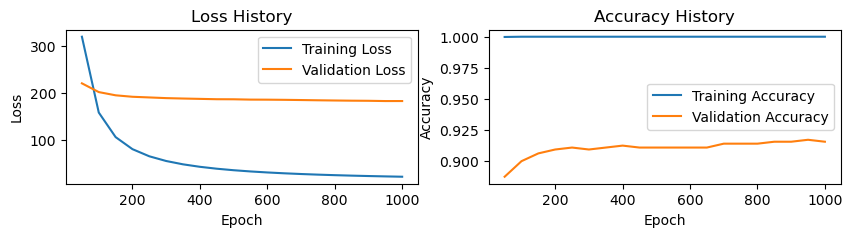

Accuracy is: 91.56 %
F1 Score is: 91.53 %
Precision of Class 0 is: 94.10 %

Classification Report:
             precision   recall f1-score  support
0              94.10 %  94.69 %  94.39 %      320
1              88.65 %  90.62 %  89.62 %      224
2              89.29 %  84.27 %  86.71 %       89
3             100.00 %  71.43 %  83.33 %        7
accuracy                         91.56 %      640
macro avg      93.01 %  85.25 %  88.51 %      640
weighted avg   91.59 %  91.56 %  91.53 %      640

Confusion Matrix:
     0    1   2  3
0  303   13   4  0
1   17  203   4  0
2    2   12  75  0
3    0    1   1  5


Accuracy is: 94.38 %
F1 Score is: 94.39 %
Precision of Class 0 is: 97.40 %

Classification Report:
             precision   recall f1-score  support
0              97.43 %  94.69 %  96.04 %      320
1              91.42 %  95.09 %  93.22 %      224
2              91.21 %  92.22 %  91.71 %       90
3             100.00 %  83.33 %  90.91 %        6
accuracy                         94.

0

In [7]:
# Train New Model
model_parameters = TrainModel(
    max_epoch=1000, batch_size=512, weight_init='zero', lr=0.01, lr_type='momentum: 0.90', regularization='l2: 0.01')

GridSearch(model_parameters, X_train, y_train, X_val, y_val, X_test, y_test, print_result=True, seed=42)

os.system(finish_sound)

In [ ]:
# # Train new model
# now = datetime.datetime.now().strftime("%d-%m-%H-%M")

# # Fit model 
# model = LogisticRegression()
# model.fit(X_train, y_train, X_val, y_val, now, max_epoch=1000,
#           batch_size=5120, weight_init='zero', lr=0.01, lr_type='momentum: 0.99', regularization='l2: 0.01')
# model.save_weights()
# model.plot()

# # Validation Set Results
# y_pred = model.predict(X_val)
# results = EvaluateModel(y_val, y_pred, 'val', now)

# # Test Set Results
# y_pred = model.predict(X_test)
# results = EvaluateModel(y_test, y_pred, 'test', now)

# # play sound when finished
# os.system(finish_sound)

In [66]:
# Load Trained Model and Evaluate

# #now = open('model-comparison/last.txt', 'r').read()
# now = 'deneme'
# model = LogisticRegression()
# model.load_weights(now)
# model.load_history()

# # Validation Set Results
# model.plot(save=False)
# y_pred = model.predict(X_val)
# results = EvaluateModel(y_val, y_pred, 'val', now, save=False)

# # Test Set Results
# y_pred = model.predict(X_test)
# results = EvaluateModel(y_test, y_pred, 'test', now, save=False)

In [24]:
# Grid Search Combinations

max_epoch = [1000]
weight_init = ['zero', 'uniform', 'normal']
batch_size = [1, 512, 5120]
lr = [0.01, 0.005, 0.001]
lr_type = ['static', 'adaptive', 'momentum: 0.99']
regularization = ['l2: 0.01', 'l2: 0.001', 'l2: 0.0001', 'l1: 0.01', 'l1: 0.001', 'l1: 0.0001']
params = [max_epoch, weight_init, batch_size, lr, lr_type, regularization]
model_options = list(product(*params))
print('Number of combinations:', len(model_options))
print('Combination 1:', model_options[0])

Number of combinations: 486
Combination 1: (1000, 'zero', 1, 0.01, 'static', 'l2: 0.01')


In [28]:
GridSearch(model_options[0], X_train, y_train, X_val, y_val, X_test, y_test)
os.system(finish_sound)

Model  1  saved with name:  24-11-02-55
(1000, 0.01, 'static', 'l2: 0.01') Val-Accuracy: 0.878125
1 models left to train.
Model  2  saved with name:  24-11-02-57
(1000, 0.01, 'static', 'l2: 0.001') Val-Accuracy: 0.878125
0 models left to train.
Best Model is: 24-11-02-55 with validation accuracy: 87.81 %


0